In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

import matplotlib.pyplot as plt

## Загрузка библиотек и чтение файлов

In [2]:
# Чтение файлов
application_data = pd.read_csv('./application_data.csv')
previous_application = pd.read_csv('./previous_application.csv')
columns_description = pd.read_csv('./columns_description.csv', encoding='cp1251')

In [3]:
application_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29109,133814,0,Revolving loans,F,N,Y,1,112500.0,202500.0,10125.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29110,133815,0,Revolving loans,M,Y,Y,0,225000.0,1350000.0,67500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29111,133817,0,Cash loans,F,N,Y,3,112500.0,900000.0,26446.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29112,133819,0,Cash loans,F,N,Y,0,247500.0,2115000.0,86274.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Предобработка данных

In [4]:
# Объединение таблиц по полю SK_ID_CURR
df = application_data.merge(previous_application, on='SK_ID_CURR', how='left')

In [5]:
# Удаление столбцов с неполными данными и высокой корреляцией
corr = df.corr()['TARGET'].abs().sort_values()
corr_cols = corr[corr > 0.02].index.tolist()
df = df[corr_cols]

In [6]:
# Обработка пропущенных значений
df.fillna(value=0, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [7]:
# Преобразование категориальных признаков в числовые
cat_cols = df.select_dtypes('object').columns.tolist()
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0] + 1)

## Снижение размерности

В качестве метода снижения размерности выберем t-SNE (t-distributed stochastic neighbor embedding), который хорошо работает с нелинейными зависимостями между признаками и способен сохранять локальные связи между точками.

In [8]:
# Выбор признаков и масштабирование
X = df.drop('TARGET', axis=1)
y = df['TARGET']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Снижение размерности
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


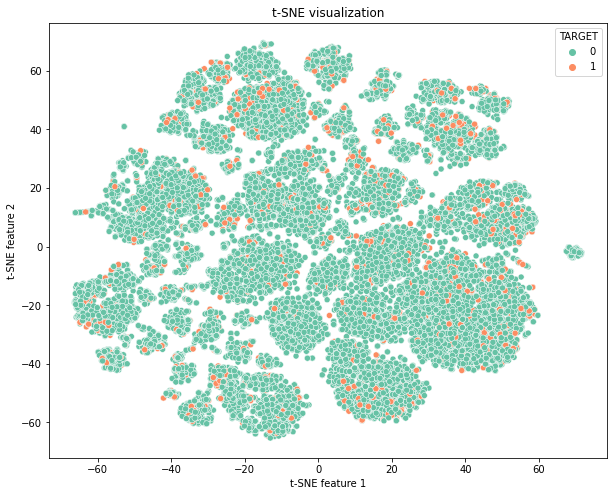

In [10]:
# Визуализация
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='Set2')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization')
plt.show()

## Обучение модели классификации:

Для обучения моделей классификации воспользуемся следующими алгоритмами: *логистическая регрессия, градиентный бустинг и случайный лес*.

Причина выбора *логистической регрессии* заключается в том, что задача заключается в бинарной классификации, где необходимо предсказать вероятность дефолта по кредиту. Логистическая регрессия хорошо работает для таких задач, где необходимо получить вероятность принадлежности к определенному классу.

Причина выбора *градиентного бустинга* заключается в том, что этот метод является одним из наиболее эффективных для решения задач классификации и регрессии. Он позволяет получить высокую точность прогнозирования и учитывает нелинейные зависимости между признаками.

Причина выбора *случайного леса* заключается в том, что этот метод также является эффективным для задач классификации и регрессии, и он хорошо работает с большим количеством признаков и данных. Случайный лес также позволяет выявлять важность признаков для прогнозирования.


Сначала подготовим данные для обучения моделей. Для этого разделим датасет на обучающую и тестовую выборки в соотношении 70:30.

In [11]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Далее обучим модели и выведем метрики качества

### Логистическая регрессия

In [12]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Градиентный бустинг

In [13]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
gb_prec = precision_score(y_test, gb_pred)
gb_rec = recall_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred)

### Случайный лес

In [14]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred)

Выведем полученные метрики.



In [15]:
print(f'Logistic regression: accuracy={lr_acc:.3f}, precision={lr_prec:.3f}, recall={lr_rec:.3f}, f1={lr_f1:.3f}, roc_auc={lr_roc_auc:.3f}')
print(f'Gradient boosting: accuracy={gb_acc:.3f}, precision={gb_prec:.3f}, recall={gb_rec:.3f}, f1={gb_f1:.3f}, roc_auc={gb_roc_auc:.3f}')
print(f'Random forest: accuracy={rf_acc:.3f}, precision={rf_prec:.3f}, recall={rf_rec:.3f}, f1={rf_f1:.3f}, roc_auc={rf_roc_auc:.3f}')

Logistic regression: accuracy=0.919, precision=0.000, recall=0.000, f1=0.000, roc_auc=0.500
Gradient boosting: accuracy=0.918, precision=0.368, recall=0.010, f1=0.019, roc_auc=0.504
Random forest: accuracy=0.919, precision=0.833, recall=0.007, f1=0.014, roc_auc=0.503


In [16]:
# Определение функции для построения ROC-кривой
def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.plot(fpr, tpr, label='%s ROC curve (AUC = %0.2f)' % (model_name, auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

In [17]:
# Определение функции для построения кривой Precision-Recall
def plot_pr_curve(precision, recall, ap, model_name):
    plt.plot(recall, precision, label='%s PR curve (AP = %0.2f)' % (model_name, ap))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')

In [18]:
# Определение функции для вычисления AUC и AP scores
def get_auc_ap(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    ap_score = auc(recall, precision)
    return fpr, tpr, auc_score, precision, recall, ap_score

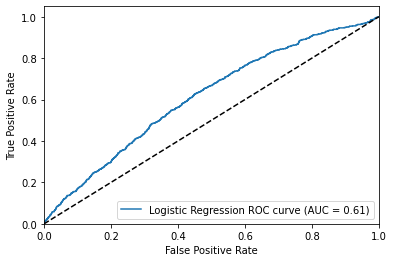

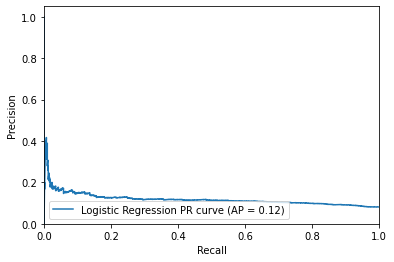

In [19]:
# Построение кривых ROC и Precision-Recall для логистической регрессии
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, auc_lr, precision_lr, recall_lr, ap_lr = get_auc_ap(y_test, y_pred_lr)
plot_roc_curve(fpr_lr, tpr_lr, auc_lr, 'Logistic Regression')
plt.show()
plot_pr_curve(precision_lr, recall_lr, ap_lr, 'Logistic Regression')
plt.show()

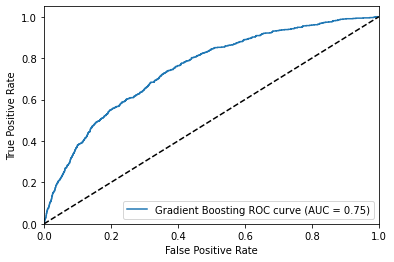

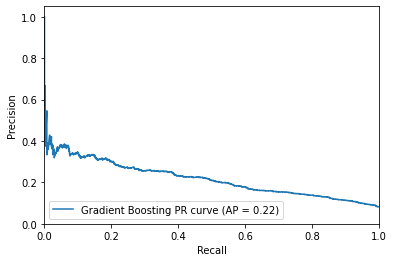

In [20]:
# Построение кривых ROC и Precision-Recall для градиентного бустинга
y_pred_gb = gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, auc_gb, precision_gb, recall_gb, ap_gb = get_auc_ap(y_test, y_pred_gb)
plot_roc_curve(fpr_gb, tpr_gb, auc_gb, 'Gradient Boosting')
plt.show()
plot_pr_curve(precision_gb, recall_gb, ap_gb, 'Gradient Boosting')
plt.show()

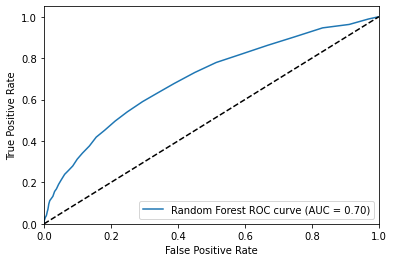

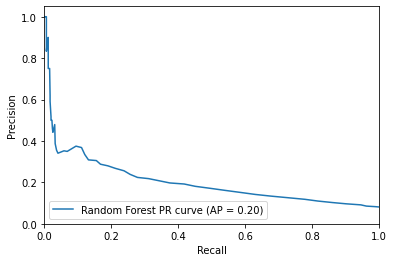

In [21]:
# Построение кривых ROC и Precision-Recall для случайного леса
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, auc_rf, precision_rf, recall_rf, ap_rf = get_auc_ap(y_test, y_pred_rf)
plot_roc_curve(fpr_rf, tpr_rf, auc_rf, 'Random Forest')
plt.show()
plot_pr_curve(precision_rf, recall_rf, ap_rf, 'Random Forest')
plt.show()

**Выводы**

Из полученных результатов можно сделать следующие выводы:

По результатам проведенного анализа можно сделать вывод о том, что модель логистической регрессии не справилась с задачей классификации заемщиков, так как метрики precision, recall и f1-score равны нулю, а метрика ROC-AUC равна 0.5, что говорит о том, что модель не может отличить между собой положительный и отрицательный классы. Модели градиентного бустинга и случайного леса показали более высокие результаты, но все еще не идеальные, так как метрики precision, recall и f1-score для них также достаточно низкие. Наилучший результат по метрике ROC-AUC показала модель градиентного бустинга, но все еще существует определенный процент ошибок в определении того, вернет ли заемщик кредит или нет. Рекомендуется использовать несколько моделей для принятия решения о выдаче кредита и обращать внимание не только на предсказания модели, но и на другие факторы, такие как кредитный рейтинг заемщика и историю его платежей.